# MCMC using backward filtering, forward guiding for shapes

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebook [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb) for a simpler version with $\mathbb R^2$ data. In the present version, the node covariance is constant throughout the tree similarly to [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb). Shape dependent node covariance will follow in a later version.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_tree_2d_scatter, plot_tree_2d_shape, plot_shape_2d

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

# Shape related setup

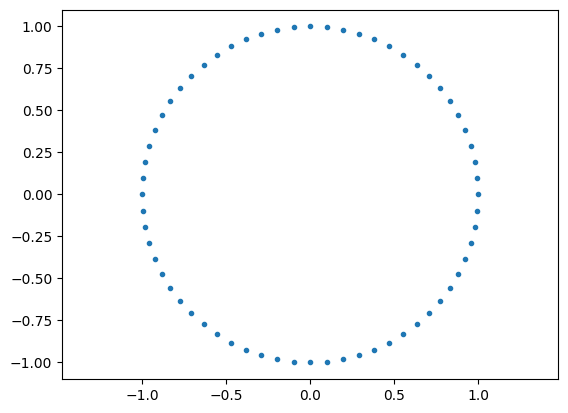

In [4]:
# define shape and plot
d = 2; n = 64 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape = plot_shape_2d
plot_shape(root)

In [5]:
# diffusion and covariance specification for shape processes
kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# evaluate k on one landmark configurations against itself with each landmark pair resulting in a dxd matric
# i,jth entry of result is kQ12(x_i,x_j)*eye(d)
def Q12(q,params): 
    A = jnp.einsum('ij,kl->ikjl',kQ12_q(q,q,params),jnp.eye(2))
    return A.reshape((A.shape[0]*A.shape[1],A.shape[2]*A.shape[3]))

# diffusion matrix
sigma = lambda params: Q12(root,params)
# covariance matrix
def a(params): _sigma = sigma(params); return jnp.einsum('ij,kj->ik',_sigma,_sigma)

# Gaussian tree, constant node covariance

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
topology = symmetric_topology(height=2, degree=5)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(n*d,))
tree.add_property('noise', shape=(n*d,))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                        o
    ┌─────────┬─────────┼─────────┬─────────┐
    o         o         o         o         o    
┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐
o o o o o o o o o o o o o o o o o o o o o o o o o
HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.3), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is sqare of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        return {'value': parent_value+jnp.sqrt(var)*jnp.einsum('ij,j->i',sigma(params),noise)}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# copy the sampled tree and add noise to leaf nodes
key, subkey = split(key)
leaf_values = tree.data['value'][tree.is_leaf]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,tree.data['value'][tree.is_leaf].shape)
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)

Plot a generated tree.

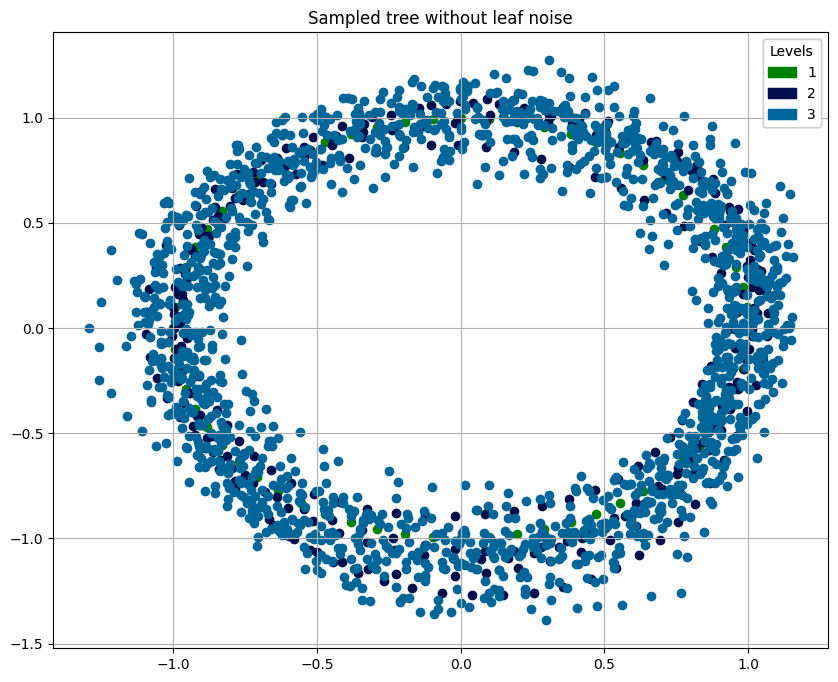

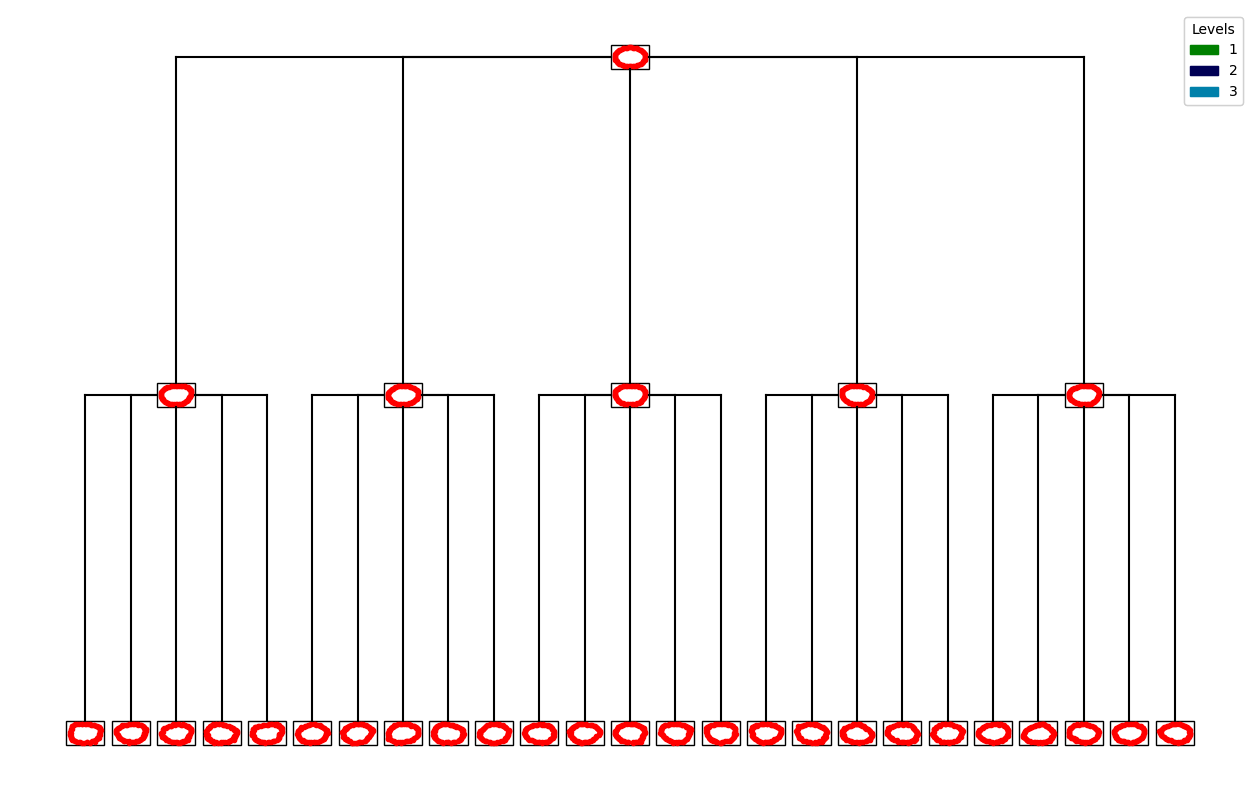

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((1,n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
@jax.jit
def up(noise,edge_length,F_T,H_T,params,**args):
    def f(noise,edge_length,F_T,H_T):
        var = edge_length # variance is edge length
        covar = var*a(params) # covariance matrix

        Sigma_T = jnp.linalg.inv(H_T)
        v_T = Sigma_T@F_T
    
        invPhi_0 = (jnp.eye(n*d)+H_T@covar)
        Sigma_0 = Sigma_T@invPhi_0 # = Sigma_T+covar
        H_0 = jnp.linalg.inv(Sigma_0)
        F_0 = jnp.linalg.solve(invPhi_0,F_T)
        v_0 = Sigma_0@F_0
        c_0 = -jax.scipy.stats.multivariate_normal.logpdf(v_0,jnp.zeros(n*d),Sigma_0)
    
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(noise,edge_length,F_T,H_T)
def transform(child_c_0,child_F_0,child_H_0,**args):
    return {'c_T': child_c_0, 'F_T': child_F_0, 'H_T': child_H_0}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree for up
tree.add_property('c_0'); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n*d,n*d)); tree.add_property('c_T'); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n*d,n*d))
def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n*d)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jnp.einsum('bij,bj->bi',tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n*d)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: -jax.scipy.stats.multivariate_normal.logpdf(v,jnp.zeros(n*d),Sigma))(leaf_values))


We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
@jax.jit
def down_conditional(noise,edge_length,F_T,H_T,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,parent_value):
        x = parent_value
        var = edge_length # variance is edge length
        covar = var*a(params) # covariance matrix

        invSigma = jnp.linalg.inv(covar)
        H = H_T+invSigma
        mu = jnp.linalg.solve(H,F_T+invSigma@x)
        #return {'value': mu+jnp.linalg.solve(jnp.real(jax.scipy.linalg.sqrtm(H)),noise)}
        return {'value': mu+jax.scipy.linalg.solve_triangular(jax.scipy.linalg.cholesky(H,lower=True),noise)}

    return jax.vmap(f)(noise,edge_length,F_T,H_T,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)


We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# time the operations
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 584 μs, sys: 671 μs, total: 1.25 ms
Wall time: 1.28 ms
CPU times: user 63 ms, sys: 4.32 ms, total: 67.4 ms
Wall time: 53.1 ms
CPU times: user 102 ms, sys: 5.77 ms, total: 108 ms
Wall time: 79.1 ms


We test the setup by sampling a number of trees and computing mean and covariance of the leaf data.

In [16]:
# do statistics on the leaf values
F = tree.data['F_T'][0]; H = tree.data['H_T'][0]
print("root conditional mean vs. sample mean:",jnp.linalg.solve(H,F),jnp.mean(leaf_values,0))
print("root conditional cov vs. sample cov:",jnp.linalg.inv(H),jnp.cov(leaf_values.T))

# sample statistics
K = 500 # number samples
samples = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_noise = jnp.zeros((K,sum(tree.is_leaf),n*d))
samples_conditional = jnp.zeros((K,sum(tree.is_leaf),n*d))

for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(tree,subkey)
    down_unconditional.down(tree,params.values())
    values = tree.data['value'][tree.is_leaf]
    # collect values
    samples = samples.at[i].set(values)
    # add observation noise
    subkey,key = jax.random.split(key)
    samples_noise = samples_noise.at[i].set(values+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,values.shape))
    # conditional sampling
    update_noise(tree,subkey)
    down_conditional.down(tree,params.values())
    samples_conditional = samples_conditional.at[i].set(tree.data['value'][tree.is_leaf])
# print sample statistics for all leaves
print("data parameters: ",params.values())
print("observation noise: ")
print(" mean: ",jnp.mean(samples_conditional-leaf_values,axis=(0,1)))
print(" cov: ",jnp.cov((samples_conditional-leaf_values).reshape(-1,n*d).T))
print("leaves: ")
for i in range(samples.shape[1]):
    print("  mean: ",jnp.mean(samples[:,i],0))
    print("  cov: ",jnp.cov(samples[:,i].T))
    print("  mean w/ noise: ",jnp.mean(samples_noise[:,i],0))
    print("  cov w/ noise: ",jnp.cov(samples_noise[:,i].T))
    print("  mean conditional: ",jnp.mean(samples_conditional[:,i],0), ", sample: ",leaf_values[i])
    print("  cov conditional: ",jnp.cov(samples_conditional[:,i].T))
    print("  mean noise: ",jnp.mean(samples_conditional[:,i]-leaf_values[i],0))
    print("  cov noise: ",jnp.cov((samples_conditional[:,i]-leaf_values[i]).T))

root conditional mean vs. sample mean: [ 1.00837248 -0.01701296  1.01585655  0.08617565  1.00884139  0.18734535
  1.00497061  0.27117413  0.98620529  0.36048249  0.94639992  0.44451679
  0.89977775  0.51984863  0.83119436  0.61293541  0.77597245  0.67313081
  0.70639973  0.74656093  0.62225824  0.80998668  0.54953308  0.86653492
  0.46392699  0.90975126  0.36960905  0.95655297  0.28302804  0.97603091
  0.20616295  0.99720456  0.09608485  1.00831697  0.00336152  1.01415762
 -0.09541895  0.99960465 -0.19236003  0.98327144 -0.29565149  0.95423581
 -0.39625248  0.91607405 -0.49491171  0.85639364 -0.58821843  0.81092333
 -0.65976192  0.75431125 -0.75363161  0.67304585 -0.81144269  0.58674184
 -0.87470282  0.52529655 -0.90362561  0.4127154  -0.94758596  0.30439627
 -0.97323489  0.21803913 -1.00127415  0.10863827 -0.98936837  0.00153095
 -0.98721888 -0.11399086 -0.97848633 -0.21792293 -0.94731582 -0.30708609
 -0.90942261 -0.39692974 -0.87614191 -0.50725207 -0.82518013 -0.59711022
 -0.76310555

100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.25, 'obs_var': 0.001}
observation noise: 
 mean:  [ 1.28016494e-04  5.42040445e-03  1.20460815e-04 -9.28784894e-04
  5.20983936e-03 -7.58340185e-03 -3.40281054e-03  3.61973872e-04
 -8.41228417e-03 -2.19076640e-04 -3.82598083e-03  1.18454732e-03
 -3.36683930e-03  7.71381793e-03  9.15842337e-03 -7.47819602e-03
 -1.42057797e-04  5.71416167e-03 -1.95115981e-03  4.32041819e-04
  5.43613231e-03 -9.10445617e-04 -2.70159613e-03 -2.33420530e-03
 -1.18532021e-03  1.75228521e-03  6.30289704e-03 -6.30706183e-03
  3.50318992e-03  3.79761895e-03 -1.15823428e-02  2.63549029e-03
  3.93087321e-03  1.70600616e-03 -4.13922251e-04 -3.89379415e-03
 -8.02891180e-04  9.88770020e-04 -4.36925894e-03 -2.09729782e-03
 -1.70297965e-03 -1.99021959e-03 -3.43511773e-04 -1.96525623e-03
  2.25431306e-03  1.06821185e-02  4.48413774e-03  4.62282199e-04
 -8.34582298e-03 -7.01119100e-03  9.31052948e-03  2.00506985e-03
  1.96658676e-04  8.25191401e-03  6.56512999e-03 -1.76283

# MCMC

We make two MCMC runs: First, we use that the model with constant node covariance is fully Gaussian and we can read the data likelihood directly from the results of upwards pass. Subsequently, we also sample the state of the tree to get a likelihood approximation from the conditional downwards pass. This version is not necessary in the current model, but it points towards how inference in non-Gaussian models (e.g. non-linear diffusion processes along the edges) will look.

Initial parameters:  {'k_alpha': 0.25, 'k_sigma': 0.5, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.25, 'obs_var': 0.001}


100%|██████████| 1200/1200 [01:38<00:00, 12.16it/s]

Acceptance rate: 0.3650


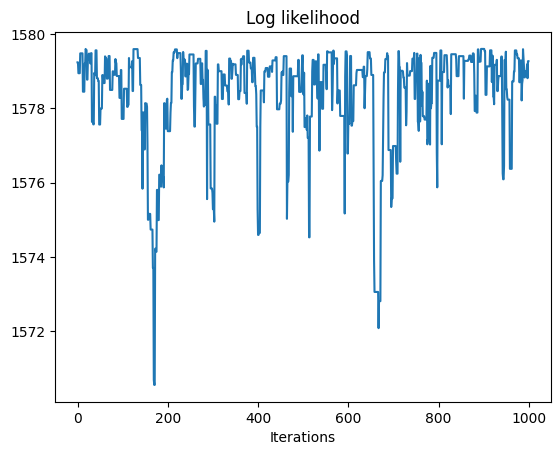

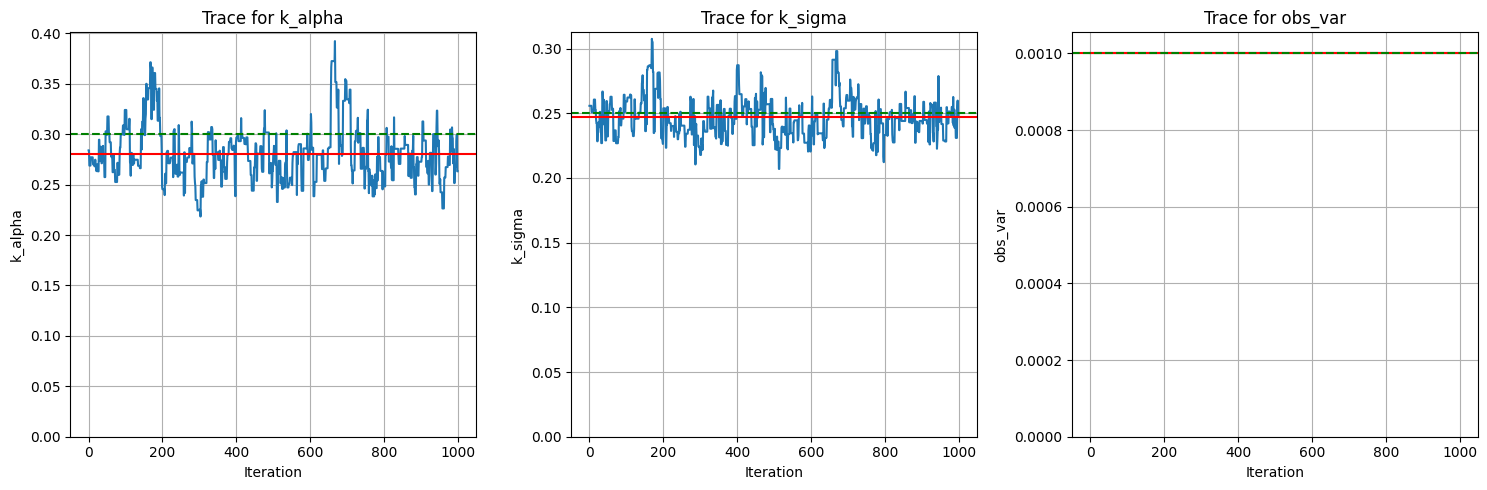

In [17]:
# inference for Gaussian model, likelihood from backwards filtering
def log_likelihood(state):
    """Log likelihood of the tree."""
    params, = state
    v,c,F,H = tree.data['value'][0],tree.data['c_T'][0],tree.data['F_T'][0],tree.data['H_T'][0]
    #c = -jnp.real(jax.scipy.stats.multivariate_normal.logpdf(v,jnp.zeros(n*d),jnp.linalg.inv(H)))
    return -c+F@v-.5*v.T@H@v

def log_posterior(data,state):
    """Log posterior given the state and data."""
    params, = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())

    log_prior = params.log_prior()
    log_like = log_likelihood(state)
    return log_prior + log_like

def proposal(data, state, key):
    parameters, = state
    new_parameters = parameters.propose(key)

    return new_parameters,

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.25,keep_constant=False), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5,keep_constant=False), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003,keep_constant=True) # observation noise variance. We keep it constant here because of lacking identifiability (which will not be the case with higher-dimensional correlated data)
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = init_params,

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods,samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 1000, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,true_params=params.values())

Initial parameters:  {'k_alpha': 0.1, 'k_sigma': 0.25, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.25, 'obs_var': 0.001}


100%|██████████| 1200/1200 [02:46<00:00,  7.23it/s]


Acceptance rate: 0.6250


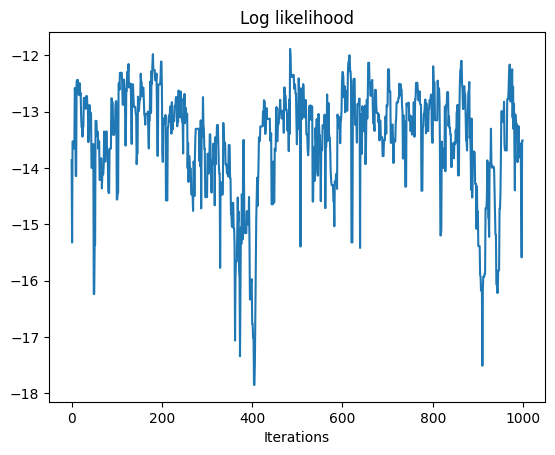

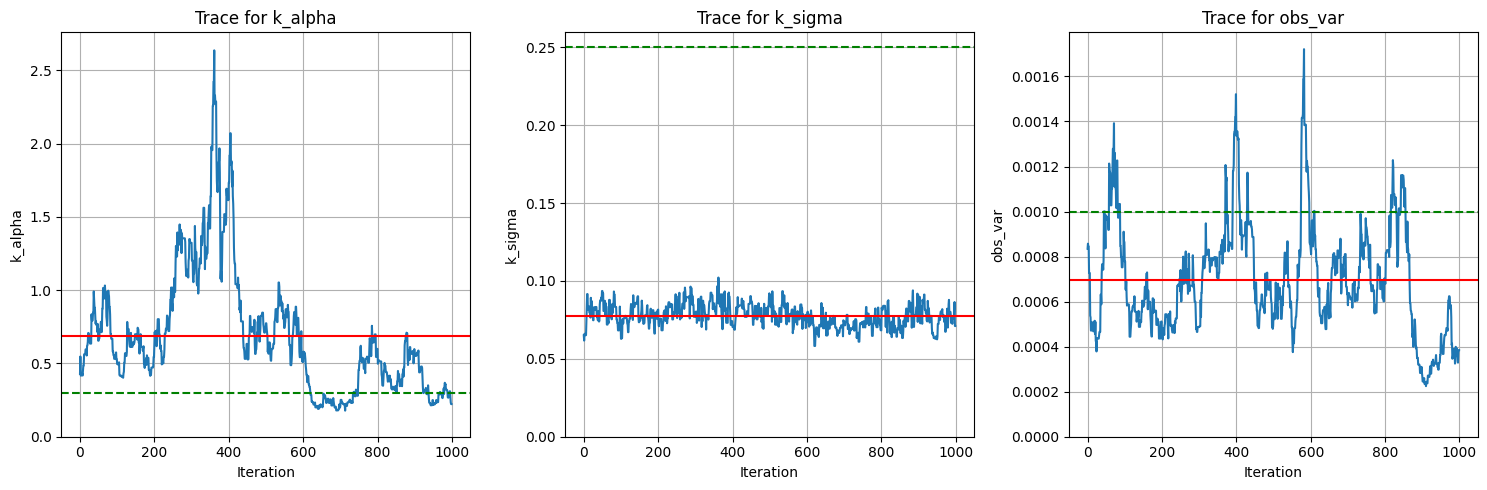

In [18]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# downwards pass to compute likelihoods
tree.add_property('log_likelihood', shape=())
@jax.jit
def down_log_likelihood(noise,value,edge_length,parent_value,params,**args):
    var = edge_length # variance is edge length
    covar = a(params)/params['k_alpha']**2 # covariance without amplitude
    sqrt_covar = sigma(params)/params['k_alpha'] # square root covariance without amplitude
    return {'log_likelihood': jnp.mean(
        jax.vmap(lambda v,m,var: jax.scipy.stats.norm.logpdf(jnp.linalg.solve(sqrt_covar,v-m),0,jnp.sqrt(var)*params['k_alpha']))(value,parent_value,var)
        ,1)
        }
downmodel_log_likelihood = DownLambda(down_fn=down_log_likelihood)
down_log_likelihood = OrderedExecutor(downmodel_log_likelihood)

# log likelihood of the tree
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    # compute log likelihood
    down_log_likelihood.down(tree,params.values())
    tree_log_likelihood = jnp.mean(tree.data['log_likelihood'][1:]) # ignore root node
    residuals = tree.data['value'][tree.is_leaf]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.1,alpha=3,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 1000, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,true_params=params.values())